In [34]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")



import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from bs4 import BeautifulSoup
#nltk.download()
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

from scipy.sparse import csr_matrix 
from sklearn.preprocessing import StandardScaler 
from sklearn.manifold import TSNE

In [3]:
# using the SQLite Table to read data.
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
con = sqlite3.connect('C:/BEFORE/MINIPJ/Personal/AMAZON food review/database.sqlite')
print(con)
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition)                          #map==>map() function returns a list of the results after applying the given function to each item of a given iterable (list, tuple etc.)
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [4]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [7]:
display['COUNT(*)'].sum()

393063

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [9]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [11]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [13]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

In [15]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [16]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it, it would poison them. Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut, facts though say otherwise. Until the late 70 is it was poisonous until they figured out a way to fix that. I still like it but it could be better.


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great ingredients although chicken should have been 1st rather than chicken broth the only thing I do not think belongs in it is Canola oil Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it it would poison them Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut facts though say otherwise Until the late 70 is it was poisonous until they figured out a way to fix that I still like it but it could be better 


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])
#stop_words = set(stopwords.words('english'))

In [22]:
# Combining all the above stundents 
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):    #values==>The method values() returns a list of all the values available in a given dictionary.
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()         #BeautifulSoup==>
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 364171/364171 [04:12<00:00, 1442.66it/s]


In [23]:
preprocessed_reviews[1500]

'great ingredients although chicken rather chicken broth thing not think belongs canola oil canola rapeseed not someting dog would ever find nature find rapeseed nature eat would poison today food industries convinced masses canola oil safe even better oil olive virgin coconut facts though say otherwise late poisonous figured way fix still like could better'

In [24]:
#TO REDUCE THE NUMBER OF DATA POINTS TO 5K


# using the SQLite Table to read data.
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
con5k = sqlite3.connect('C:/BEFORE/MINIPJ/Personal/AMAZON food review/database.sqlite')
filtered_data5k = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con5k) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition5k(a):
    if a < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore5k = filtered_data5k['Score']
positiveNegative5k = actualScore5k.map(partition5k) 
filtered_data5k['Score'] = positiveNegative5k
print("Number of data points in our data", filtered_data5k.shape)
filtered_data5k.head(3)

#Sorting data according to ProductId in ascending order
sorted_data5k=filtered_data5k.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

#Deduplication of entries
final5k=sorted_data5k.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final5k.shape

final5k=final5k[final5k.HelpfulnessNumerator<=final5k.HelpfulnessDenominator]

# printing some random reviews
sent_05k = final5k['Text'].values[0]
#print(sent_05k)
#print("="*50)

sent_10005k = final5k['Text'].values[1000]
#print(sent_10005k)
#print("="*50)

sent_15005k = final5k['Text'].values[1500]
#print(sent_15005k)
#print("="*50)

sent_49005k = final5k['Text'].values[4900]
#print(sent_49005k)
#print("="*50)

# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_05k = re.sub(r"http\S+", "", sent_05k)
sent_10005k = re.sub(r"http\S+", "", sent_10005k)
sent_1505k = re.sub(r"http\S+", "", sent_15005k)
sent_49005k = re.sub(r"http\S+", "", sent_49005k)

#print(sent_05k)

# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted5k(phrase5k):
    # specific
    phrase5k = re.sub(r"won't", "will not", phrase5k)
    phrase5k = re.sub(r"can\'t", "can not", phrase5k)

    # general
    phrase5k = re.sub(r"n\'t", " not", phrase5k)
    phrase5k = re.sub(r"\'re", " are", phrase5k)
    phrase5k = re.sub(r"\'s", " is", phrase5k)
    phrase5k = re.sub(r"\'d", " would", phrase5k)
    phrase5k = re.sub(r"\'ll", " will", phrase5k)
    phrase5k = re.sub(r"\'t", " not", phrase5k)
    phrase5k = re.sub(r"\'ve", " have", phrase5k)
    phrase5k = re.sub(r"\'m", " am", phrase5k)
    return phrase5k

#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_05k = re.sub("\S*\d\S*", "", sent_05k).strip()
#print(sent_05k)

#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_15005k = re.sub('[^A-Za-z0-9]+', ' ', sent_15005k)
#print(sent_15005k)

# Combining all the above stundents 
preprocessed_reviews5k = []
# tqdm is for printing the status bar
for sentance5k in tqdm(final5k['Text'].values):
    sentance5k = re.sub(r"http\S+", "", sentance5k)
    sentance5k = BeautifulSoup(sentance5k, 'lxml').get_text()
    sentance5k = decontracted5k(sentance5k)
    sentance5k = re.sub("\S*\d\S*", "", sentance5k).strip()
    sentance5k = re.sub('[^A-Za-z]+', ' ', sentance5k)
    # https://gist.github.com/sebleier/554280
    sentance5k = ' '.join(e.lower() for e in sentance5k.split() if e.lower() not in stopwords)
    preprocessed_reviews5k.append(sentance5k.strip())

Number of data points in our data (5000, 10)


100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:03<00:00, 1463.87it/s]


# BOW

In [25]:
#BoW
count_vect = CountVectorizer() #in scikit-learn ...........converts text doc to sparse maatrix
count_vect.fit(preprocessed_reviews5k)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts5k = count_vect.transform(preprocessed_reviews5k)
print("the type of count vectorizer ",type(final_counts5k))
print("the shape of out text BOW vectorizer ",final_counts5k.get_shape())
print("the number of unique words ", final_counts5k.get_shape()[1])

some feature names  ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 12997)
the number of unique words  12997


In [26]:
from scipy.sparse import csr_matrix 

In [27]:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.toarray.html#scipy.sparse.csr_matrix.toarray

#Converting the Sparse matrix to dense matrices 
dense_matrix = csr_matrix.toarray(final_counts5k,order=None,out=None) 
print(dense_matrix.shape) 

(4986, 12997)


In [28]:
# standardizing our data before applying tsne 
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html 
#----------------and------------------------------
#https://github.com/isapansoni/ML-models-on-Amazon-fine-food-reviews/blob/master/TSNE_Amazon_Food_Review.ipynb

from sklearn.preprocessing import StandardScaler 
standardized_data = StandardScaler().fit_transform(dense_matrix)
print(standardized_data.shape)

C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(4986, 12997)


C:\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


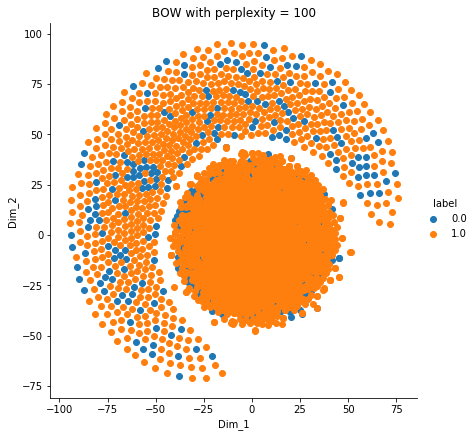

In [87]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0,perplexity=90)
standardized_data = model.fit_transform(standardized_data)

labels = final5k['Score']
labels.shape

standardized_data = np.vstack((standardized_data.T,labels)).T
tsne_df = pd.DataFrame(data=standardized_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('BOW with perplexity = 100')
plt.show()

# AVG W2V

In [29]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews5k:
    list_of_sentance.append(sentance.split())

In [30]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=True
want_to_use_google_w2v = True
want_to_train_w2v = False

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('C:/Users/sesha/OneDrive/Desktop/ICONS/IMP/before/MINIPJ/Personal/AMAZON food review/GoogleNews-vectors-negative300.bin.gz'):
        w2v_model=KeyedVectors.load_word2vec_format('C:/Users/sesha/OneDrive/Desktop/ICONS/IMP/before/MINIPJ/Personal/AMAZON food review/GoogleNews-vectors-negative300.bin.gz', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have google's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('terrific', 0.798933207988739), ('fantastic', 0.7935211658477783), ('tremendous', 0.7748855948448181), ('wonderful', 0.7647868394851685), ('good', 0.7291510105133057), ('incredible', 0.7032873630523682), ('marvelous', 0.6971103549003601), ('phenomenal', 0.6841564774513245), ('amazing', 0.6634128093719482), ('awesome', 0.6510506868362427)]
[('Worst', 0.6146091818809509), ('weakest', 0.6143776178359985), ('scariest', 0.5957258939743042), ('ugliest', 0.5931181311607361), ('best', 0.5835109949111938), ('bleakest', 0.5718506574630737), ('strongest', 0.5671455264091492), ('nastiest', 0.5644308924674988), ('lousiest', 0.5631451606750488), ('toughest', 0.5624395608901978)]


In [31]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3000000
sample words  ['</s>', 'in', 'for', 'that', 'is', 'on', '##', 'The', 'with', 'said', 'was', 'the', 'at', 'not', 'as', 'it', 'be', 'from', 'by', 'are', 'I', 'have', 'he', 'will', 'has', '####', 'his', 'an', 'this', 'or', 'their', 'who', 'they', 'but', '$', 'had', 'year', 'were', 'we', 'more', '###', 'up', 'been', 'you', 'its', 'one', 'about', 'would', 'which', 'out']


In [32]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(300) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████████████████████████████████████████████████████████████████████████| 4986/4986 [07:20<00:00, 11.32it/s]


4986
300


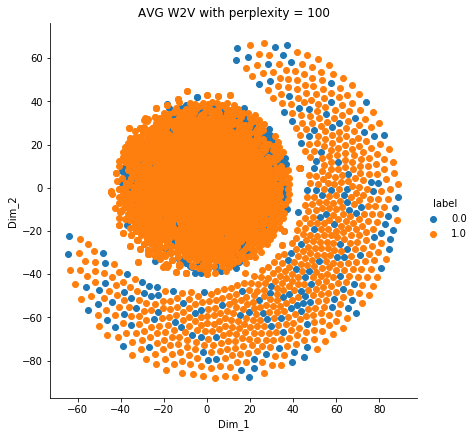

In [35]:
model = TSNE(n_components=2, random_state=0,perplexity=150)
standardized_data = model.fit_transform(standardized_data)

labels = final5k['Score']
labels.shape

standardized_data = np.vstack((standardized_data.T,labels)).T
tsne_df = pd.DataFrame(data=standardized_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('AVG W2V with perplexity = 100')
plt.show()

# TFIDF


In [36]:
#bi-gram, tri-gram and n-gram
from sklearn.feature_extraction.text import TfidfVectorizer
#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# you can choose these numebrs min_df=10, max_features=5000, of your choice
Tfidf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = Tfidf_vect.fit_transform(preprocessed_reviews5k)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


In [37]:
#Converting the Sparse matrix to dense matrices 
from scipy.sparse import csr_matrix 
dense_matrix_tfidf = csr_matrix.toarray(final_bigram_counts,order=None,out=None) 
print(dense_matrix_tfidf.shape) 

(4986, 3144)


In [38]:
# standardizing our data before applying tsne 
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html 
#----------------and------------------------------
#https://github.com/isapansoni/ML-models-on-Amazon-fine-food-reviews/blob/master/TSNE_Amazon_Food_Review.ipynb

from sklearn.preprocessing import StandardScaler 
standardized_data_tfidf = StandardScaler().fit_transform(dense_matrix_tfidf)
print(standardized_data_tfidf.shape)

(4986, 3144)


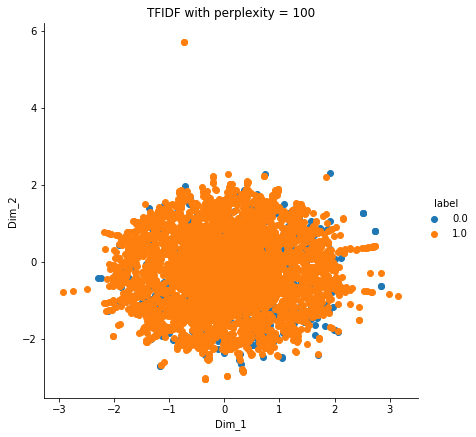

In [39]:
from sklearn.manifold import TSNE
model_tfidf = TSNE(n_components=2, random_state=0,perplexity=150)
standardized_data_tfidf = model_tfidf.fit_transform(standardized_data_tfidf)

labels_tfidf = final5k['Score'] 
labels_tfidf.shape

standardized_data_tfidf = np.vstack((standardized_data_tfidf.T,labels_tfidf)).T
tsne_df_tfidf = pd.DataFrame(data=standardized_data_tfidf, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df_tfidf, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('TFIDF with perplexity = 100')
plt.show()

# TFIDF W2V

In [40]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews5k:
    list_of_sentance.append(sentance.split())

In [41]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
model.fit(preprocessed_reviews5k)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [42]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(300) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████████████████████████████████████████████████████████████████████████| 4986/4986 [05:09<00:00, 10.74it/s]


In [43]:
# standardizing our data before applying tsne 
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html 
#----------------and------------------------------
#https://github.com/isapansoni/ML-models-on-Amazon-fine-food-reviews/blob/master/TSNE_Amazon_Food_Review.ipynb

standardized_data = StandardScaler().fit_transform(tfidf_sent_vectors)
print(standardized_data.shape)

(4986, 300)


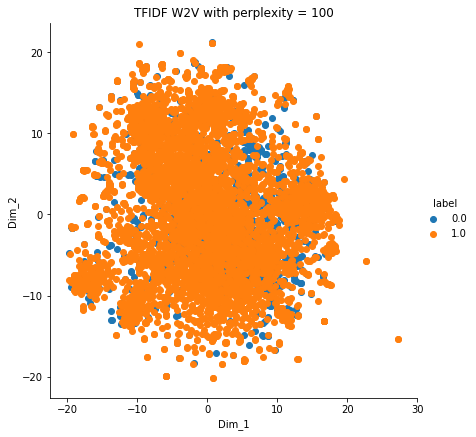

In [44]:
model = TSNE(n_components=2, random_state=0,perplexity=150)
standardized_data = model.fit_transform(standardized_data)

labels = final5k['Score']
labels.shape

standardized_data = np.vstack((standardized_data.T,labels)).T
tsne_df = pd.DataFrame(data=standardized_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('TFIDF W2V with perplexity = 100')
plt.show()